In [1]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
plt.style.use('ggplot')
# plt.rcParams.update({'font.size': 16})
# plt.rcParams['savefig.dpi'] = 200
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'lightgrey'

In [2]:
pd.set_option('display.max_columns', None)

pop_spotify = pd.read_pickle("data/spotify_df.pkl")

In [3]:
pop_spotify.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,month
95157,2c07kosP5G3qP4vHhwoUMT,In And Out Of Love - ilan Bluestone & Maor Lev...,30,263432,0,"['Armin van Buuren', 'Sharon Den Adel', 'Ilan ...","['0SfsnGyD8FpIN4U4WCkBZ5', '2GST08xzn3dJilysjD...",2020-12-11,0.352,0.736,1,-4.781,1,0.1300,0.01930,0.000020,0.3600,0.102,129.987,4,2020,12
87847,1wd5l8qYJ4AlgAhPGQxZq4,Im,30,228069,0,['Alma Zohar'],['61Sbigb2Faz8K27wBoOBo9'],2015-07-15,0.702,0.572,7,-9.597,1,0.0289,0.25900,0.000000,0.0946,0.327,129.985,4,2015,7
86833,3n1vpIDGakzAbo2p2etvhN,Taras e manias,30,248813,0,['Marco Paulo'],['5LxTQtpFwvokioLWNkrDQr'],2013-01-14,0.613,0.558,11,-6.149,1,0.0387,0.53200,0.000000,0.1260,0.529,110.069,4,2013,1
95155,0MbIwfFvlLpK2yW6w3kmbd,Time Machine (Mixed),30,49676,0,"['Craig Connelly', 'Tara Louise']","['78UUH1buA0gDtDnkX2dPgL', '6rCzXE6L3H7Eihb4Bg...",2020-12-11,0.508,0.887,4,-8.721,0,0.1370,0.00441,0.987000,0.1270,0.648,135.215,4,2020,12
79426,6WmvWYAnshYAAXZRD1hqck,Eime Enas Allos - Original,30,214693,0,['Nino Xypolitas'],['1ATDcv6wTF2U42HPB4qEFz'],2006-01-01,0.644,0.996,11,-5.938,1,0.1030,0.00346,0.000001,0.3680,0.517,142.995,4,2006,1


In [4]:
samp = np.random.randint(low=0,high=1900000,size=100000)
samp

array([  41194, 1489838,  434398, ...,  794532,  605772, 1597719])

In [5]:
sample_df = pop_spotify.iloc[samp]

In [6]:
samp_df2 = sample_df[['popularity','duration_ms','explicit','danceability','energy','key','loudness','mode', 'speechiness','acousticness','instrumentalness','liveness','valence','tempo']]

In [7]:
# pop_df = pop_spotify[['popularity','danceability', 'instrumentalness', 'loudness', 'speechiness', 'explicit','liveness','duration_ms']]

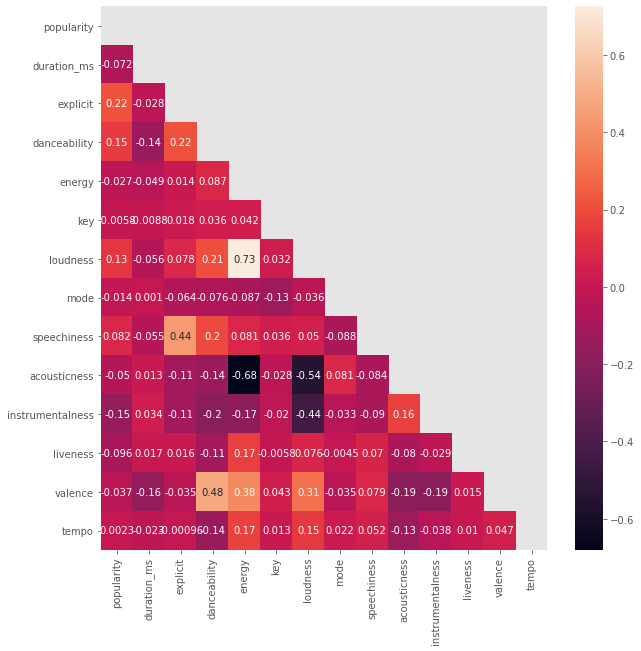

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(samp_df2.corr(), annot=True, mask=np.triu(samp_df2.corr()));

In [9]:
# dance = pop_df[['popularity','danceability']]
# avg_dance = pop_df.groupby('popularity').mean()

In [10]:
# fig, ax = plt.subplots(figsize=(14,5),squeeze=True)

# ax.plot(avg_dance.index, avg_dance.danceability,color='navy',alpha=0.5)
# ax.scatter(avg_dance.index, avg_dance.danceability,color='blue',s=20)
# ax.set_title('Average Danceability as Popularity Increases')
# ax.set_xlabel('Popularity')
# ax.set_ylabel('Danceability')
# plt.plot(np.unique(avg_dance.index), np.poly1d(np.polyfit(avg_dance.index, avg_dance.danceability, 1))(np.unique(avg_dance.index)),linestyle='--');
# plt.tight_layout()
# plt.show()

In [11]:
# r,p = stats.pearsonr(avg_dance.index,avg_dance.danceability)
# r,p

In [12]:
def rmse(y_true, y_predict):
    return mean_squared_error(y_true, y_predict, squared=False)

In [13]:
def cross_val(X_train, y_train, k, model):
    # Return the error for k-fold cross-val
    kf = KFold(n_splits=k)
    error = np.empty(k)
    index = 0
    
    for train, test in kf.split(X_train):
        model.fit(X_train[train], y_train[train])
        pred = model.predict(X_train[test])
        error[index] = rmse(y_train[test], pred)
        index +=1
    return np.mean(error)

In [14]:
y = samp_df2.popularity
X = samp_df2.drop(['popularity'], axis=1)


In [15]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Columns'] = X.columns
vif_info.sort_values('VIF')

,VIF,Columns
9,1.424897,instrumentalness
1,1.622701,explicit
7,2.427667,speechiness
10,2.550390,liveness
6,2.708830,mode
8,3.013416,acousticness
4,3.225128,key
5,8.146566,loudness
11,8.892353,valence
0,9.991934,duration_ms


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, shuffle=True, test_size=0.2, random_state=42)

In [39]:
lr = LinearRegression().fit(X_train, y_train)
# y_hats = lr.predict(X_train)
lr.score(X_test,y_test)

0.11674136803785351

In [40]:
ridge1 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge1.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge1.score(X_test, y_test)))

Training set score: 0.11
Test set score: 0.12


In [41]:
ridge2 = Ridge(alpha=.1).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge2.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge2.score(X_test, y_test)))

Training set score: 0.11
Test set score: 0.12


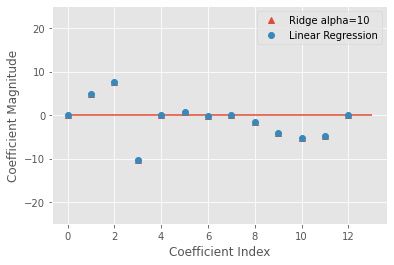

In [42]:
plt.plot(ridge1.coef_,'^',label="Ridge alpha=10")
plt.plot(lr.coef_,'o', label="Linear Regression")

plt.xlabel("Coefficient Index")
plt.ylabel("Coefficient Magnitude")
plt.hlines(0,0,len(lr.coef_))
plt.ylim(-25, 25)
plt.legend()

# Random Forest


n_estimators:
200: .79532
100: .79234
50: .79260
400: .796

In [63]:
# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [16,32,64,128]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}



In [64]:
# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=50, cv=3,random_state=42, n_jobs=-1)
# rf_random.fit(X_train,y_train)

## Training

In [65]:
rfr = RandomForestRegressor(n_estimators=50)
model = rfr.fit(X_train,y_train)
y_hats = model.predict(X_train)
print('Accuracy Test:', model.score(X_train,y_train))
print('RMSE Train:', rmse(y_train, y_hats))

Accuracy Test: 0.9631009252963711
RMSE Train: 2.1917971828198555


### Cross-validation on training data

In [66]:
# print('Cross-validation Train:', cross_val(X_train, y_train, k=7, model=RandomForestRegressor()))

## Testing

In [67]:
y_hats = model.predict(X_test)
print('Accuracy Test:', model.score(X_test,y_test))
print('RMSE Test:', rmse(y_test,y_hats))

Accuracy Test: 0.8116785757142968
RMSE Test: 4.95901162794916


* With **Testing Accuracy** < **Training Accuracy**, this indicates an overfitting of the model. Need to generalize the model more.

### Cross-validation on testing data

In [68]:
# print('Cross-validation Test:', cross_val(X_test, y_test, k=7, model=RandomForestRegressor()))

# Neural Network

In [102]:
X_train.shape

(80000, 13)

In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [18]:
model = Sequential()

In [25]:
model.add(Dense(32, activation = 'relu', input_shape = (13, 1)))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 1))

In [26]:
#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
model.fit(X_train.reshape(X_train.shape[0],X_train.shape[1], 1), y_train, epochs=20, batch_size=32)

Epoch 1/20
2500/2500 [==============================] - 8s 2ms/step - loss: 217.8448
Epoch 2/20
2500/2500 [==============================] - 6s 2ms/step - loss: 131.8062
Epoch 3/20
2500/2500 [==============================] - 6s 2ms/step - loss: 133.3502
Epoch 4/20
2500/2500 [==============================] - 6s 2ms/step - loss: 133.1504
Epoch 5/20
2500/2500 [==============================] - 6s 2ms/step - loss: 133.1380
Epoch 6/20
2500/2500 [==============================] - 6s 3ms/step - loss: 132.6745
Epoch 7/20
2500/2500 [==============================] - 6s 3ms/step - loss: 133.6611
Epoch 8/20
2500/2500 [==============================] - 6s 3ms/step - loss: 132.7321
Epoch 9/20
2500/2500 [==============================] - 6s 3ms/step - loss: 133.4817
Epoch 10/20
2500/2500 [==============================] - 6s 3ms/step - loss: 133.1581
Epoch 11/20
2500/2500 [==============================] - 6s 3ms/step - loss: 133.6476
Epoch 12/20
2500/2500 [==============================] - 7s 3ms